[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/me-manu/gammaALPs/blob/master/docs/tutorials/mixing_single_cell.ipynb)

# Mixing in a homogeneous magnetic field

This tutorial demonstrates the most simple use case of the `gammaALPs` code, namely the mixing between photons and ALPs in a homogeneous magnetic field. The magnetic-field parameters are probably not very realisitic, but the results nicely illustrate some of the main features of photon-ALP mixing. 

If you haven't installed `gammaALPs` already, you can do so using `pip`. Just uncomment the line below:

In [1]:
#!pip install gammaALPs

We first import the relevant modules:

In [2]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base.transfer import EminGeV, EmaxGeV
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c

And set the ALP parameters:

In [3]:
m, g = 10., 3.
alp = ALP(m, g)

Let's define an energy range for this example, in GeV.

In [4]:
EGeV = np.logspace(0.,8.,1000)

For the initial polarization, we use a fully polarized photon beam,

In [5]:
pin = np.diag((1., 0., 0.))

And we define some dummy source:

In [6]:
src = Source(z=0., l=0., b=0.)

With the defined `alp`, `src`, initial polarization `pin` and energy range `EGeV`, we can now initialize our module list

In [7]:
ml = ModuleList(alp, src, pin=pin, EGeV=EGeV, seed=0)

We add a single propagation enivironment, mixing in a cell-like field in a galaxy cluster. 
By setting `eta` and `beta` to zero, we force the electron density to be constant, so 
that neither the magnetic field nor the electron density change with propagation distance. 
We choose arbitrary values for B-field strength and electron density that give nice results for illustration. 

In [8]:
ml.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=1.,  # B field strength
                   L0=10.,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=10.001,  # full path, chosen that we only have a single cell
                   beta=0., 
                   eta=0.
                  )

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0


Now we explicitly set the angle $\psi$ between the transversal magnetic field and the $x$ direction to $\pi / 2$ so that the $x$ polarization will fully mix. 

In [9]:
ml.modules[0].psin = np.ones_like(ml.modules[0].psin) * np.pi / 2.

We run the photon-ALP calculation to get the final oscillation probabilities into the two photon polarization states and into the ALP state

In [10]:
px, py, pa = ml.run()
print (pa.shape)

   core.py: 652 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>


(1, 1000)


/Users/manuelmeyer/Python/gammaALPs/gammaALPs/base/transfer.py:799: UserWarning: Not all values of linear polarization are real values!
  warnings.warn("Not all values of linear polarization are real values!")
/Users/manuelmeyer/Python/gammaALPs/gammaALPs/base/transfer.py:802: UserWarning: Not all values of circular polarization are real values!
  warnings.warn("Not all values of circular polarization are real values!")


And plot the results:

Text(0, 0.5, '$P_{a\\gamma}$')

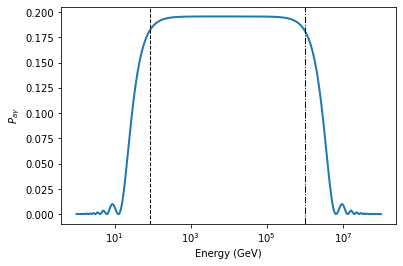

In [11]:
plt.semilogx(EGeV, pa[0], lw=2)

# the critical energy, onset of strong mixing regime
plt.axvline(EminGeV(m_neV=ml.alp.m, g11=ml.alp.g, BmuG=ml.modules[0].B, n_cm3=ml.modules[0].nel),
            lw=1., ls='--', color='k')

# maximum energy, end of strong mixing regime
plt.axvline(EmaxGeV(g11=ml.alp.g, BmuG=ml.modules[0].B),
            lw=1., ls='-.', color='k')

plt.xlabel("Energy (GeV)")
plt.ylabel("$P_{a\gamma}$")

### Sanity check

We would expect to get the same result as above if we split up the calculations over multiple cells or domains that have the same magnetic field strength and orientation. Let's see if that's the case. For this purpose, we define a second module list where we set `L0` to some smaller value that fits $n$ times into our total legth. 

In [12]:
ml_many_cells = ModuleList(alp, src, pin=pin, EGeV=EGeV, seed=0)

ml_many_cells.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=1.,  # B field strength
                   L0=0.001,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=10.001,  # full path, chosen that we only have a single cell
                   beta=0., 
                   eta=0.
                  )

ml_many_cells.modules[0].psin = np.ones_like(ml_many_cells.modules[0].psin) * np.pi / 2.

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0


Let's check how many cells we have:

In [13]:
print(ml.modules[0].psin.shape)  # first case
print(ml_many_cells.modules[0].psin.shape)  # many cell case

(1,)
(1, 10000)


Now we calculate the oscillation probability and compare:

In [14]:
px_many_cells, py_many_cells, pa_many_cells = ml_many_cells.run()

   core.py: 652 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
/Users/manuelmeyer/Python/gammaALPs/gammaALPs/base/transfer.py:799: UserWarning: Not all values of linear polarization are real values!
  warnings.warn("Not all values of linear polarization are real values!")
/Users/manuelmeyer/Python/gammaALPs/gammaALPs/base/transfer.py:802: UserWarning: Not all values of circular polarization are real values!
  warnings.warn("Not all values of circular polarization are real values!")


Absolute maximum difference: 6.081801728896608e-13


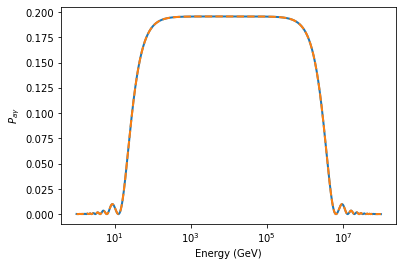

In [15]:
plt.semilogx(EGeV, pa[0], lw=2)
plt.semilogx(EGeV, pa_many_cells[0], lw=2, ls='--')

plt.xlabel("Energy (GeV)")
plt.ylabel("$P_{a\gamma}$")

print("Absolute maximum difference:", np.max(np.abs(pa[0] - pa_many_cells[0])))

As expected the difference is very close to zero and can be explained by numerical accuracy. 

### Mixing in the ALPS II experiment

We can even use `gammaALPs` to calculate the mixing in case of the ALPS II experiment! ALPS II is a light-shining-through-a-wall experiment where ALPs are produced by immersing a strong laser in a magnetic field. Some of the photons should convert to ALPs, pass a light-tight barrier, and reconvert in a magnetic field behind this wall back to photons. 

The foreseen laser in the ALPS II experiment has a wavelength of 1064 nm, and the production cavity has a length of roughly 100m. To be precise, twelve refurbished HERA dipole magnets with a length of 8.8m will be used in the experiment which have a field strength of 5.3 T. The laser beam will be polarized parallel to the magnetic field to maximize the mixing. 

We provide these specs below:

In [16]:
from astropy import units as u

In [17]:
# center energy around 1064 nm
wavelength = 1064 * u.nm
energy = ((c.c / wavelength.to('m')) * c.h).to('eV') 
print("Laser energy in eV:", energy)

# define an array centered around 1064 nm
EGeV = np.logspace(np.log10(energy.value) - 4,np.log10(energy.value) + 14.5, 2000) * u.eV.to("GeV")

# B field and length of production cavity
B = 5.3 * u.T.to('1e-6G')
L = 8.8 * 12 * u.m.to('kpc')
print(B, L)

# fully polarized beam
pin = np.diag((1., 0., 0.))

Laser energy in eV: 1.1652650228684234 eV
53000000000.0 3.42226292965325e-18


We set up the module list as before and run the calculation:

In [18]:
ml_alps = ModuleList(alp, src, pin=pin, EGeV=EGeV, seed=0)

ml_alps.add_propagation(environ='ICMCell',
                        order=0,   # order of the module
                        B0=B,  # B field strength
                        L0=L,  # cell size
                        nsim=1,  # one single realization
                        n0=1e-100,  # electron density
                        r_abell=L * 1.1,  # full path, chosen that we only have a single cell
                        beta=0., 
                        eta=0.
                        )

ml_alps.modules[0].psin = np.ones_like(ml_alps.modules[0].psin) * np.pi / 2.

# set the ALP parameters
ml_alps.alp.m = 1e4
ml_alps.alp.g = 2.

# run the calculation
px_alps, py_alps, pa_alps = ml_alps.run()

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
   core.py: 652 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
/Users/manuelmeyer/Python/gammaALPs/gammaALPs/base/transfer.py:802: UserWarning: Not all values of circular polarization are real values!
  warnings.warn("Not all values of circular polarization are real values!")


We want to compare our results against the simple formula for a two-state mixing system given by 

$$P_{a\to\gamma} = \Delta_{a\gamma}^2  \frac{\sin\left(\Delta_\mathrm{osc} L /2 \right)^2}{\left(\Delta_\mathrm{osc} L /2 \right)^2} $$

For this we first calculate the values of the momentum differences $\Delta$ and then calculate $P_{a\to\gamma}$.

In [19]:
from gammaALPs.base.transfer import Delta_a, Delta_ag, Delta_pl, Delta_QED

In [20]:
# calculate the Deltas
DQED = Delta_QED(ml_alps.modules[0].B[0], EGeV)
Dpar = Delta_pl(ml_alps.modules[0].nel[0], EGeV) + 3.5*DQED
Dpl = Delta_pl(ml_alps.modules[0].nel[0], EGeV)
Dag = Delta_ag(ml_alps.alp.g, ml_alps.modules[0].B[0]) * np.ones(EGeV.size)
Da = Delta_a(ml_alps.alp.m, EGeV)

# calculate the Dosc
Dosc = np.sqrt((Dpar - Da)**2.  + 4.*Dag**2.)

# calculate the analytical expression
Pag_analytical = Dag ** 2. * (np.sin(Dosc * L / 2.))**2. / (Dosc / 2.)**2.

And the comparison is plotted below. We find very good agreement between the code and the simple analytical expression.

Text(0, 0.5, '$P_{a\\gamma}$')

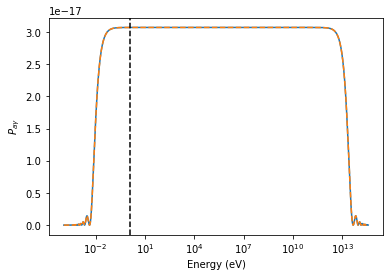

In [21]:
plt.semilogx(EGeV * 1e9, pa_alps[0])
plt.semilogx(EGeV * 1e9, Pag_analytical, ls='--')
plt.axvline(energy.value, ls='--', color='k')

plt.xlabel("Energy (eV)")
plt.ylabel("$P_{a\gamma}$")